## Mini Project

In [1]:
import torch
import time
import numpy as np

## Feature Extraction - VGG16

VGG16 is pre-trained model. We use transfer learning to apply this model to extract features from MNIST.

In [2]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [3]:
import numpy as np
from numpy.random import RandomState

prng = RandomState(42)
num = 5000
#Extract a subset of 5000 samples from MNIST training
random_permute=prng.permutation(np.arange(0,60000))[0:num]

In [4]:
x = np.zeros((num, 28, 28))
y = np.zeros(num)
for i in range(x.shape[0]):
  x[i] = x_train[random_permute[i]]
  y[i] = y_train[random_permute[i]]

In [5]:
import cv2

def change_size(x):
  x_resize = np.zeros((x.shape[0], 224, 224))
  for i in range(x.shape[0]):
    x_resize[i] = cv2.resize(x[i], (224, 224))

  x_channel = x_resize[:,:,:,np.newaxis]
  x_final = np.concatenate( (x_channel,x_channel), axis=3 )
  x_final = np.concatenate( (x_final,x_channel), axis=3 )
  return x_final

In [6]:
x_input = change_size(x)

In [7]:
from keras.applications.vgg16 import VGG16, preprocess_input

x_input = preprocess_input(x_input)

In [8]:
vgg16_base_model = VGG16(weights='imagenet', include_top=True)

Instructions for updating:
Colocations handled automatically by placer.


Here, we change the last part of VGG16.

In [9]:
from keras.models import Model

vgg16_model = Model(inputs=vgg16_base_model.input, outputs=vgg16_base_model.get_layer('fc2').output)
# vgg16_model = Model(inputs=vgg16_base_model.input, outputs=vgg16_base_model.get_layer('fc1').output)
# vgg16_model = Model(inputs=vgg16_base_model.input, outputs=vgg16_base_model.get_layer('fc1').input)

In [10]:
import time

start = time.time()

vgg16_feature = vgg16_model.predict(x_input, batch_size = 8)
vgg16_label = y

end = time.time()
end - start

875.9213712215424

In [12]:
vgg16_feature.shape

(5000, 4096)

## Visualize

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.style as style 
import matplotlib.pyplot as plt
import matplotlib

In [14]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### PCA of VGG16

In [15]:
start = time.time()

vgg16_pca_embedded = PCA(n_components=2).fit_transform(vgg16_feature)  
vgg16_pca_embedded.shape

end = time.time()
end - start

0.6254193782806396

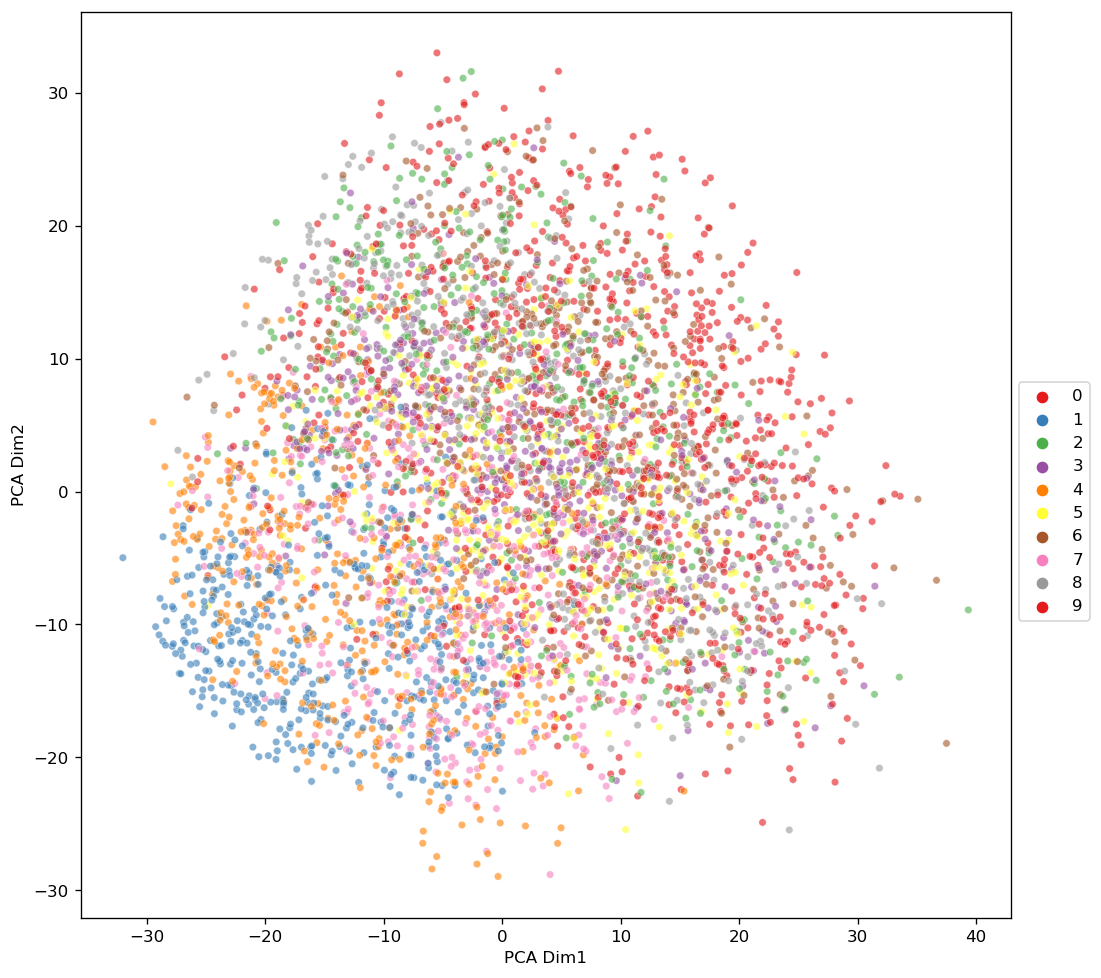

In [19]:
vgg16_pca_embedded_df = pd.DataFrame(vgg16_pca_embedded,index=vgg16_label)
vgg16_pca_embedded_df = vgg16_pca_embedded_df.reset_index()
vgg16_pca_embedded_df['index'] = vgg16_pca_embedded_df['index'].astype(int)
vgg16_pca_embedded_df_plot = vgg16_pca_embedded_df.loc[range(5000),:]
vgg16_pca_embedded_df_plot.columns = ['Label','PCA Dim1', 'PCA Dim2']
plt.figure(figsize=(10,10),dpi=120)
ax = sns.scatterplot(x='PCA Dim1', y='PCA Dim2',hue='Label',data=vgg16_pca_embedded_df_plot,
                     palette='Set1',alpha=0.6,s=20,legend='full') # tab10  Set1  husl 
legend = plt.legend(bbox_to_anchor=(1, 0.6))
plt.show()

### tSNE of scattering net
t-SNE(t-distributed stochastic neighbor embedding)

In [17]:
start = time.time()

vgg16_tsne_embedded = TSNE(n_components=2).fit_transform(vgg16_feature)

end = time.time()
end - start

185.42861533164978

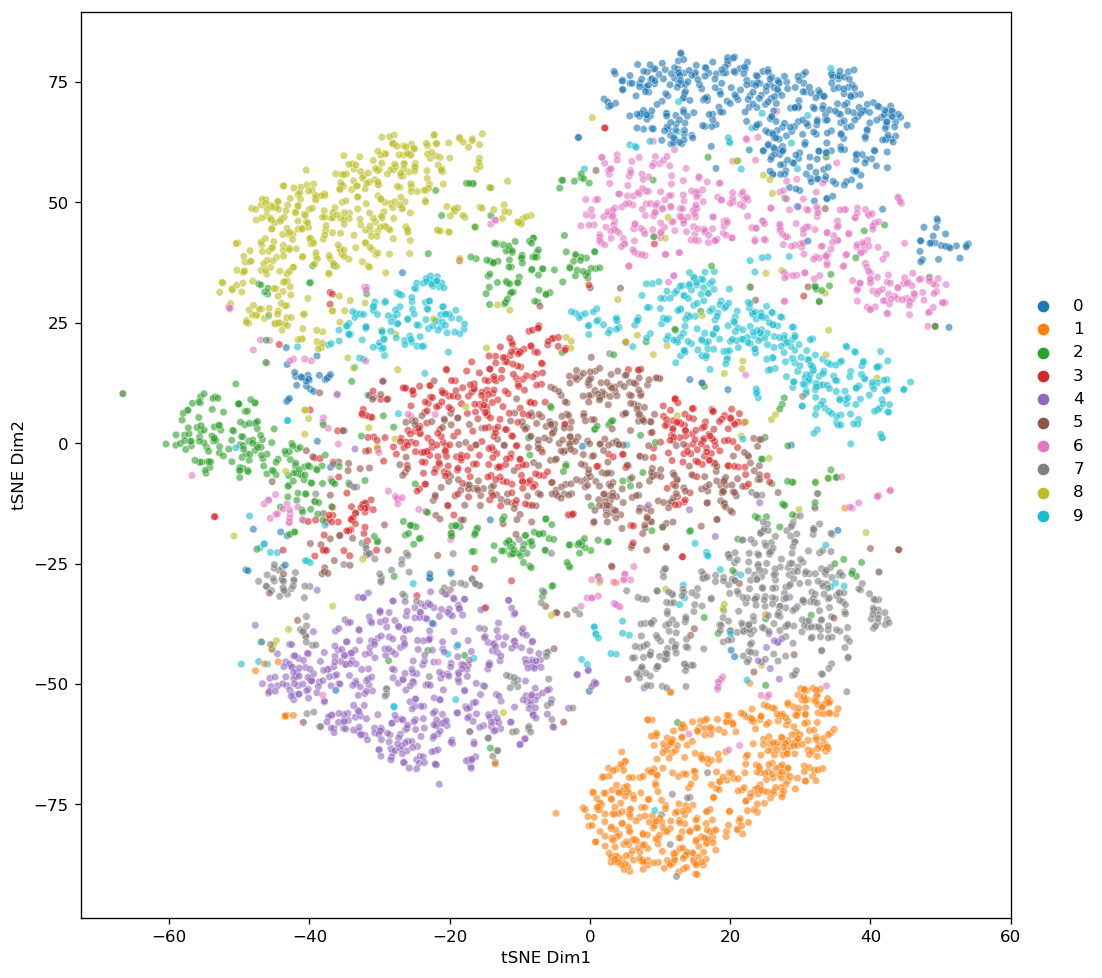

In [20]:
vgg16_tsne_embedded_df = pd.DataFrame(vgg16_tsne_embedded,index=vgg16_label)
vgg16_tsne_embedded_df = vgg16_tsne_embedded_df.reset_index()
vgg16_tsne_embedded_df['index'] = vgg16_tsne_embedded_df['index'].astype(int)
vgg16_tsne_embedded_df_plot = vgg16_tsne_embedded_df.loc[range(5000),:]
vgg16_tsne_embedded_df_plot.columns = ['Label','tSNE Dim1', 'tSNE Dim2']
plt.figure(figsize=(10,10),dpi=120)
ax = sns.scatterplot(x='tSNE Dim1', y='tSNE Dim2',hue='Label',data=vgg16_tsne_embedded_df_plot,
                     palette='tab10',alpha=0.6,s=20,legend='full')
legend = plt.legend(bbox_to_anchor=(1.001, 0.7),facecolor='white',edgecolor='white')
plt.show()

### Classifications based on features extracted by vgg16

In [21]:
from sklearn.model_selection import cross_validate

In [85]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

start = time.time()

lda = LinearDiscriminantAnalysis()

lda_results = cross_validate(lda, vgg16_feature[:5000], vgg16_label[:5000], cv=3, scoring='accuracy')
lda_results = lda_results['test_score']

end = time.time()
end - start, lda_results

(48.31731700897217, array([0.78224355, 0.76664667, 0.76470588]))

In [86]:
from sklearn.linear_model import LogisticRegression

start = time.time()

logistic_regression = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')

logistic_regression_results = cross_validate(logistic_regression, vgg16_feature[:5000], vgg16_label[:5000], cv=3, scoring='accuracy')
logistic_regression_results = logistic_regression_results['test_score']

end = time.time()
end - start, logistic_regression_results

d:\program\python\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
d:\program\python\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extr

(5.999151229858398, array([0.95560888, 0.940012  , 0.95738295]))

In [87]:
from sklearn import svm

start = time.time()

linear_svc = svm.LinearSVC()

svm_results = cross_validate(linear_svc, vgg16_feature[:5000], vgg16_label[:5000], cv=3, scoring='accuracy')
svm_results = svm_results['test_score']

end = time.time()
end - start, svm_results

d:\program\python\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
d:\program\python\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
d:\program\python\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


(22.395396947860718, array([0.96640672, 0.95920816, 0.96758703]))

In [88]:
from sklearn.ensemble import RandomForestClassifier

start = time.time()

random_forest = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)

random_forest_results = cross_validate(random_forest, vgg16_feature[:5000], vgg16_label[:5000], cv=3, scoring='accuracy')
random_forest_results = random_forest_results['test_score']

end = time.time()
end - start, random_forest_results

(1.6237835884094238, array([0.81223755, 0.80623875, 0.80912365]))

In [89]:
lda_results,logistic_regression_results,svm_results,random_forest_results

(array([0.78224355, 0.76664667, 0.76470588]),
 array([0.95560888, 0.940012  , 0.95738295]),
 array([0.96640672, 0.95920816, 0.96758703]),
 array([0.81223755, 0.80623875, 0.80912365]))

In [90]:
lda_results.mean(),logistic_regression_results.mean(),svm_results.mean(),random_forest_results.mean()

(0.7711987014361833,
 0.9510012763353691,
 0.9644006372795069,
 0.8091999847329454)

In [91]:
lda_results.std(),logistic_regression_results.std(),svm_results.std(),random_forest_results.std()

(0.007849976477019533,
 0.007804273223604595,
 0.0037031216102362207,
 0.0024495947127580932)